In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from bart_playground import *

In [3]:
notebook = "real4_Concrete"

In [4]:
from ucimlrepo import fetch_ucirepo

import numpy as np

# fetch dataset
concrete = fetch_ucirepo(id=165)

# data (as pandas dataframes)
X = concrete.data.features
y = concrete.data.targets

In [5]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [6]:
ndpost = 10000
nskip = 0
n_trees = 100

In [ ]:
from experiment import run_parallel_experiments

# Run 5 parallel experiments with different train-test splits
results = run_parallel_experiments(X, y, ndpost, nskip, n_trees, notebook, n_runs=5, n_jobs=-2)

## Default
### KPSS test

In [7]:
from diagnosis import segmented_kpss_test

=== Default BART Analysis ===

--- Run 0 ---
Sigma convergence analysis:


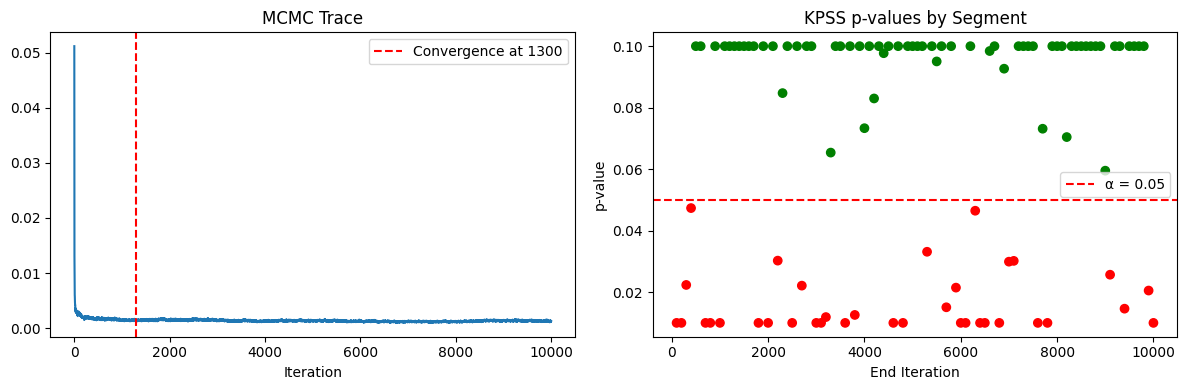

Chain converged: True
Convergence at iteration: 1300
Convergence rate: 64.00%

RMSE convergence analysis:


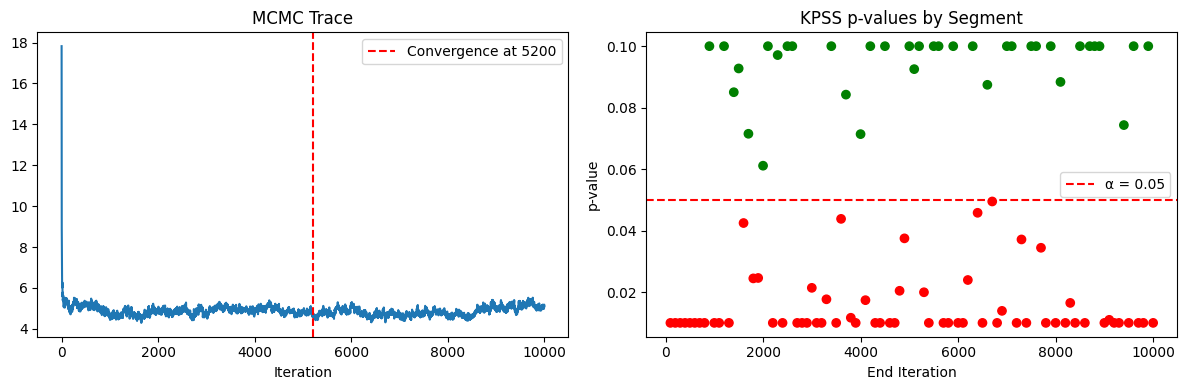

Chain converged: True
Convergence at iteration: 5200
Convergence rate: 36.00%

--- Run 1 ---
Sigma convergence analysis:


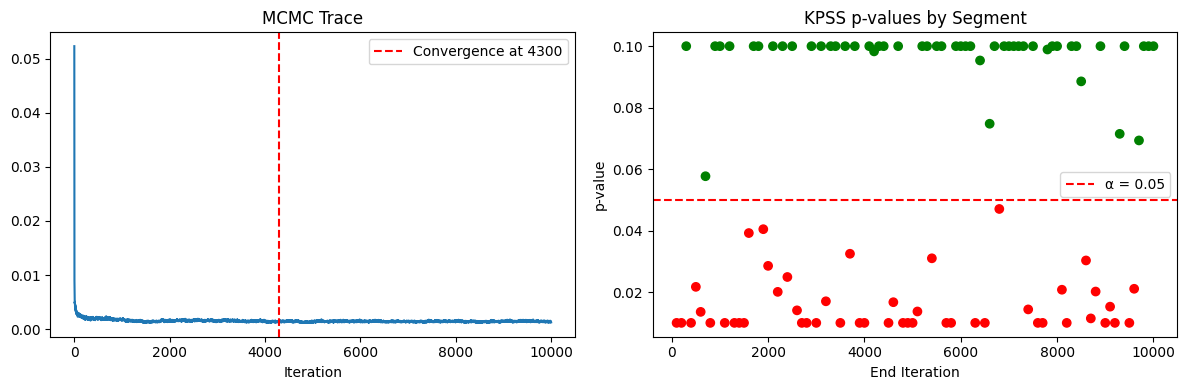

Chain converged: True
Convergence at iteration: 4300
Convergence rate: 51.00%

RMSE convergence analysis:


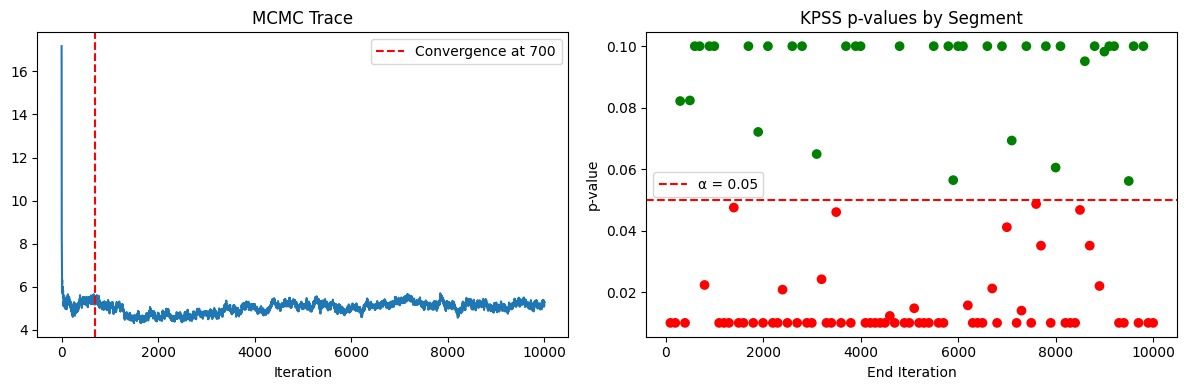

Chain converged: True
Convergence at iteration: 700
Convergence rate: 36.00%

--- Run 2 ---
Sigma convergence analysis:


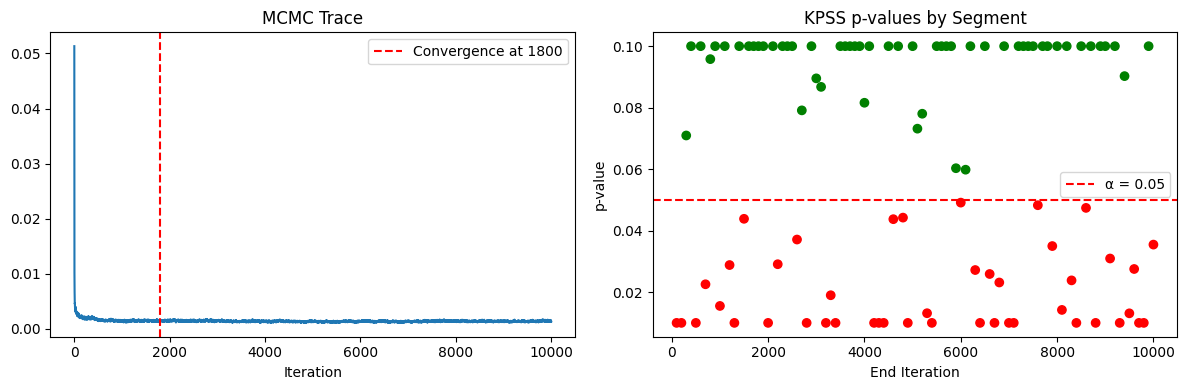

Chain converged: True
Convergence at iteration: 1800
Convergence rate: 55.00%

RMSE convergence analysis:


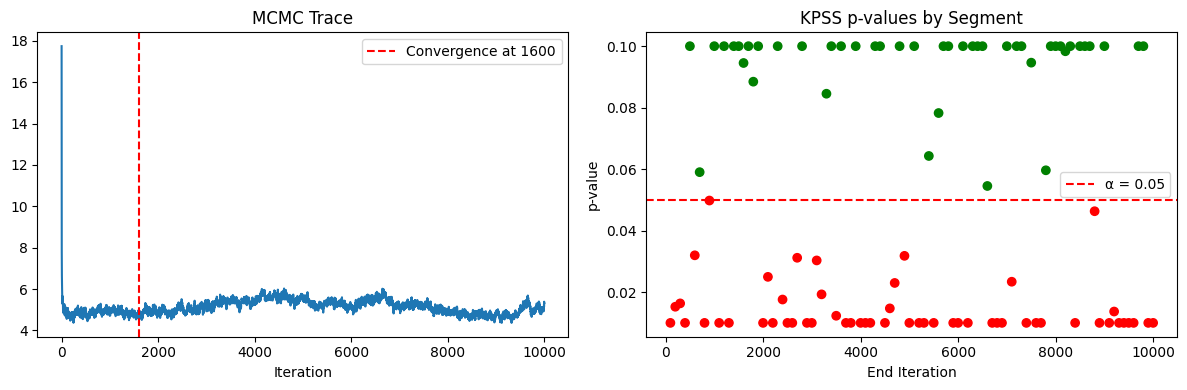

Chain converged: True
Convergence at iteration: 1600
Convergence rate: 45.00%

--- Run 3 ---
Sigma convergence analysis:


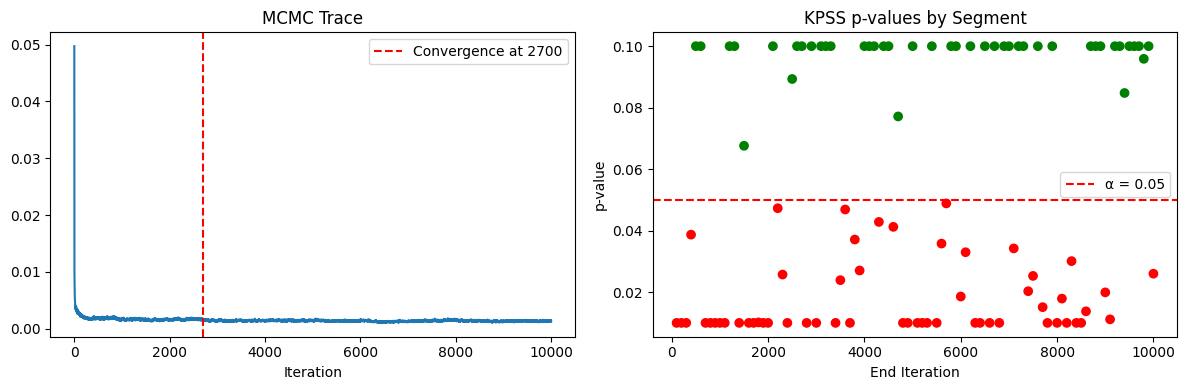

Chain converged: True
Convergence at iteration: 2700
Convergence rate: 43.00%

RMSE convergence analysis:


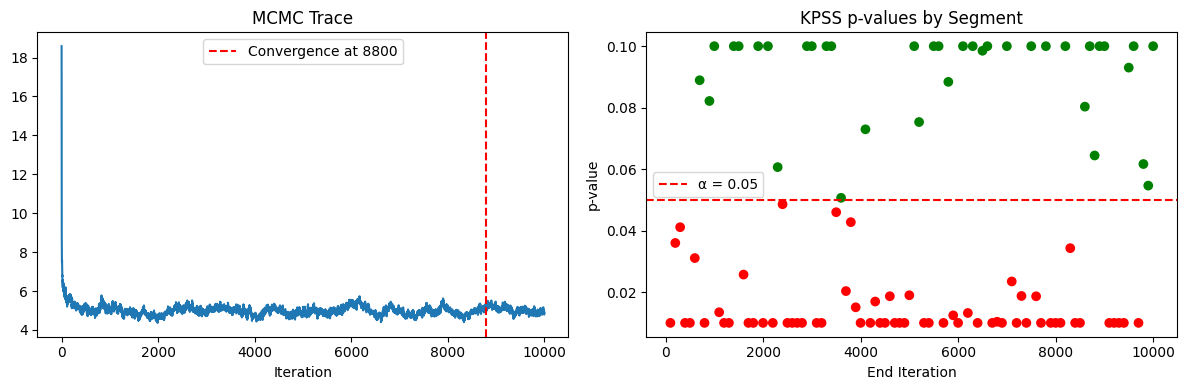

Chain converged: True
Convergence at iteration: 8800
Convergence rate: 37.00%

--- Run 4 ---
Sigma convergence analysis:


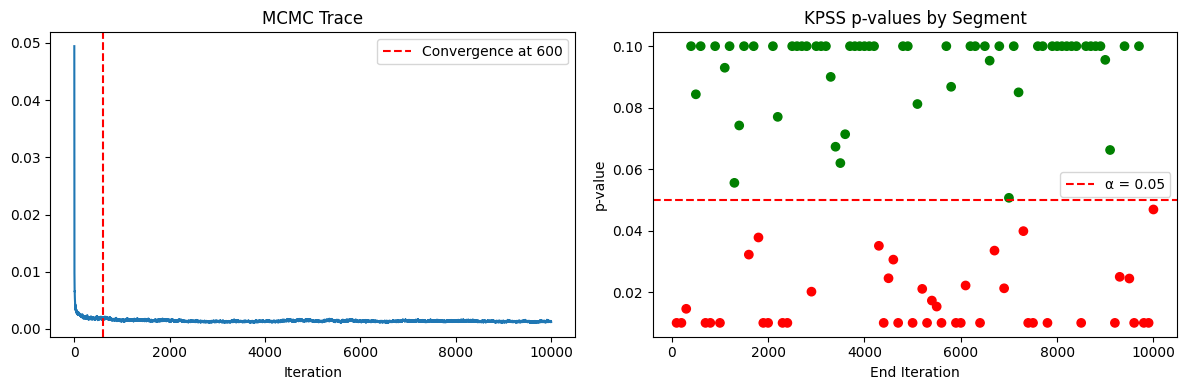

Chain converged: True
Convergence at iteration: 600
Convergence rate: 58.00%

RMSE convergence analysis:


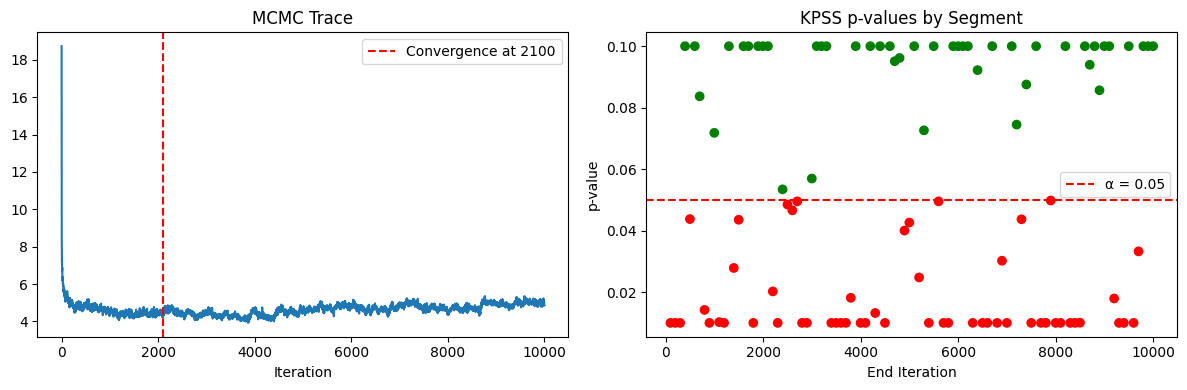

Chain converged: True
Convergence at iteration: 2100
Convergence rate: 45.00%


In [8]:
# Analyze each run's results and collect statistics
n_runs = 5

# Collect convergence statistics
default_sigma_convergence = []
default_rmse_convergence = []
default_sigma_rates = []
default_rmse_rates = []

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_default_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_default_run{run_id}.npy')
    
    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    default_sigma_rates.append(convergence_result['convergence_rate'])
    
    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    default_rmse_rates.append(convergence_result['convergence_rate'])

In [9]:
# Print summary statistics for Default BART
print("\n=== Default BART Summary ===")
if default_sigma_convergence:
    print(f"Sigma - Average convergence iteration: {np.mean(default_sigma_convergence):.0f}")
else:
    print("Sigma - No convergence detected")
print(f"Sigma - Average convergence rate: {np.mean(default_sigma_rates):.2%}")

if default_rmse_convergence:
    print(f"RMSE - Average convergence iteration: {np.mean(default_rmse_convergence):.0f}")
else:
    print("RMSE - No convergence detected")
print(f"RMSE - Average convergence rate: {np.mean(default_rmse_rates):.2%}")


=== Default BART Summary ===
Sigma - Average convergence iteration: 2140
Sigma - Average convergence rate: 54.20%
RMSE - Average convergence iteration: 3680
RMSE - Average convergence rate: 39.80%


### ESS

In [10]:
# Add logging configuration before importing arviz
import logging
logging.getLogger('arviz.preview').setLevel(logging.WARNING)
import arviz as az

In [11]:
# Analyze each run's results
n_runs = 5

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_default_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_default_run{run_id}.npy')

    print(f"Sigma ess value: {az.ess(sigmas[3000:].reshape(1, -1), relative=True).item():.6f}")
    print(f"RMSE ess value: {az.ess(rmses[3000:].reshape(1, -1), relative=True).item():.6f}")

=== Default BART Analysis ===

--- Run 0 ---
Sigma ess value: 0.001711
RMSE ess value: 0.002057

--- Run 1 ---
Sigma ess value: 0.007870
RMSE ess value: 0.000734

--- Run 2 ---
Sigma ess value: 0.008960
RMSE ess value: 0.000319

--- Run 3 ---
Sigma ess value: 0.003386
RMSE ess value: 0.005008

--- Run 4 ---
Sigma ess value: 0.003516
RMSE ess value: 0.000314


### Autocorrelation

In [12]:
from diagnosis import plot_autocorrelation

=== Default BART Analysis ===

--- Run 0 ---
Sigma autocorrelation plot:


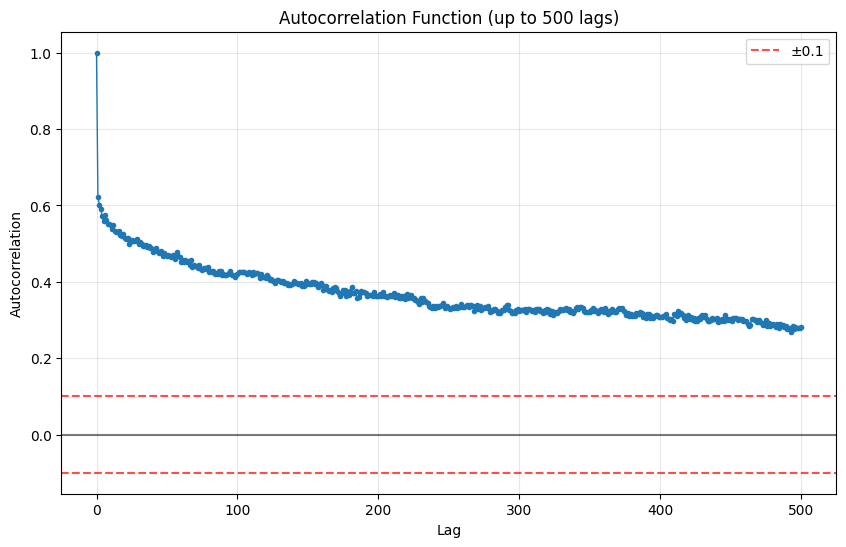

RMSE autocorrelation plot:


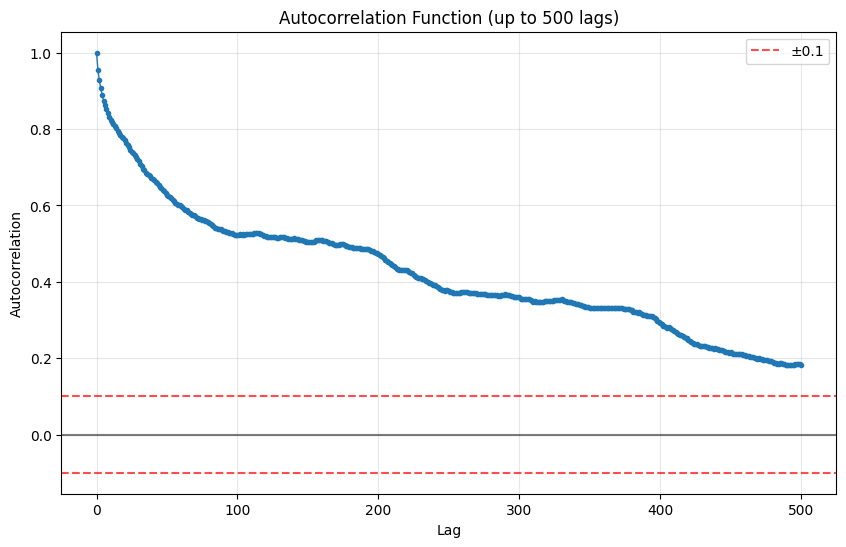


--- Run 1 ---
Sigma autocorrelation plot:


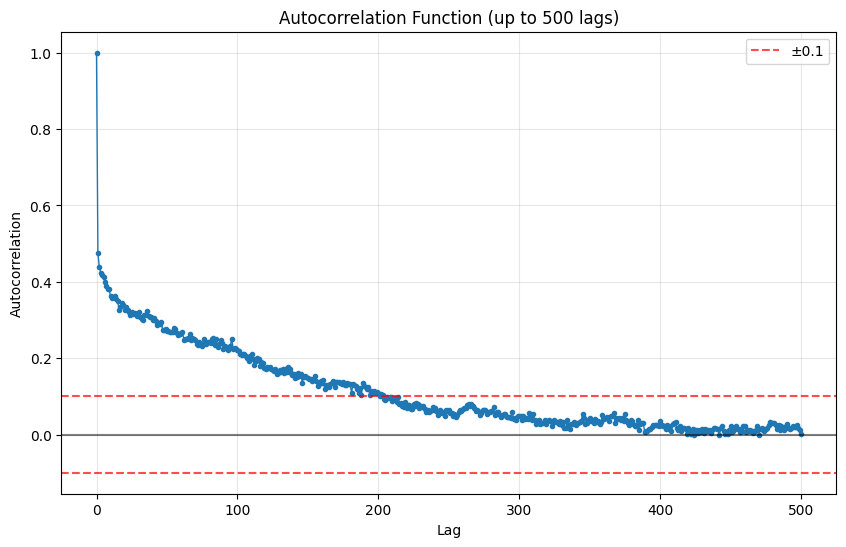

RMSE autocorrelation plot:


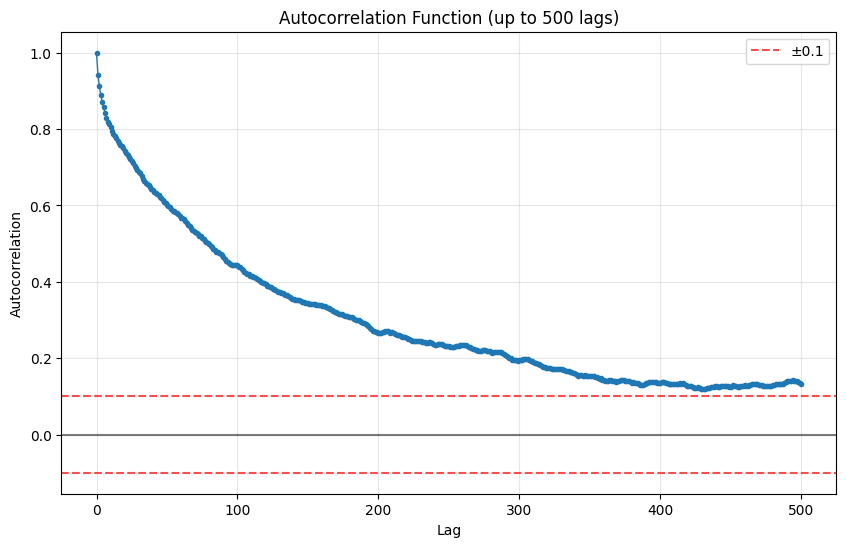


--- Run 2 ---
Sigma autocorrelation plot:


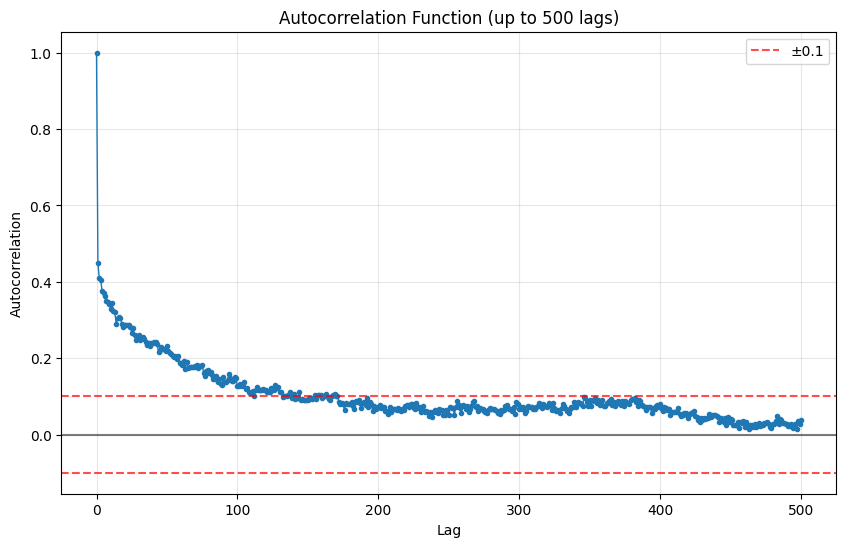

RMSE autocorrelation plot:


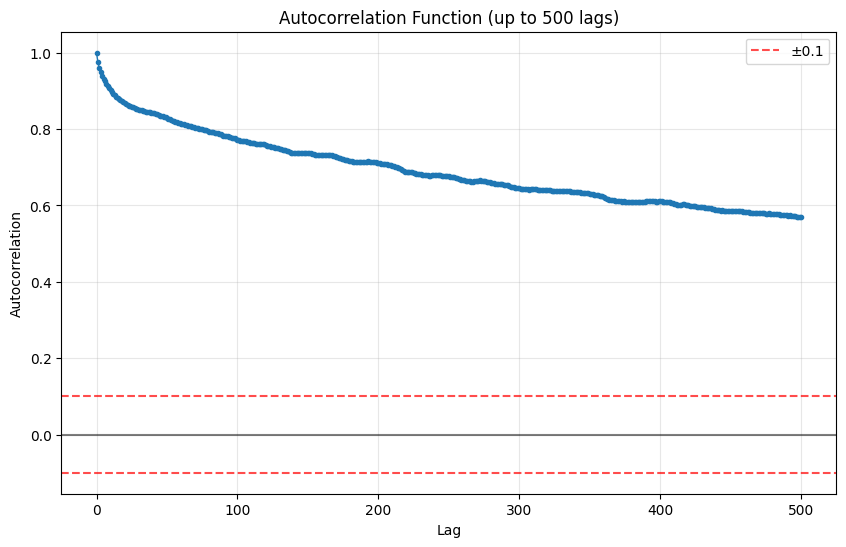


--- Run 3 ---
Sigma autocorrelation plot:


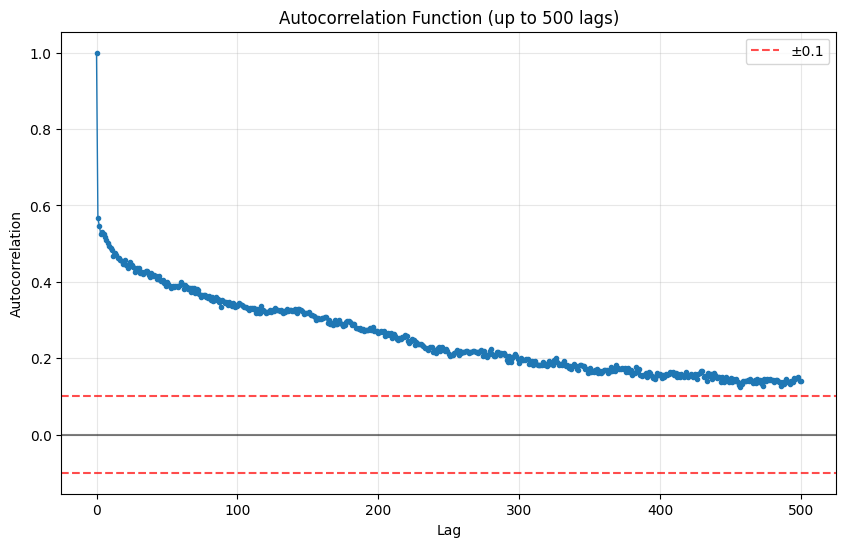

RMSE autocorrelation plot:


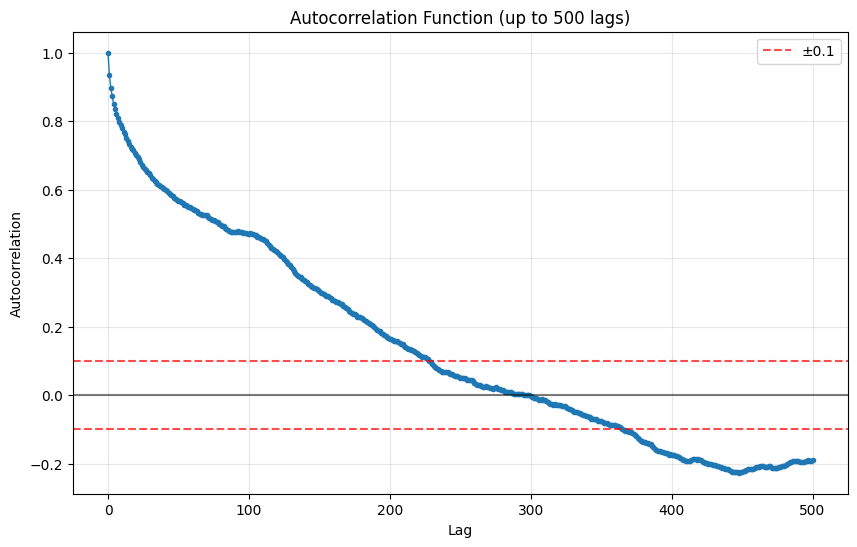


--- Run 4 ---
Sigma autocorrelation plot:


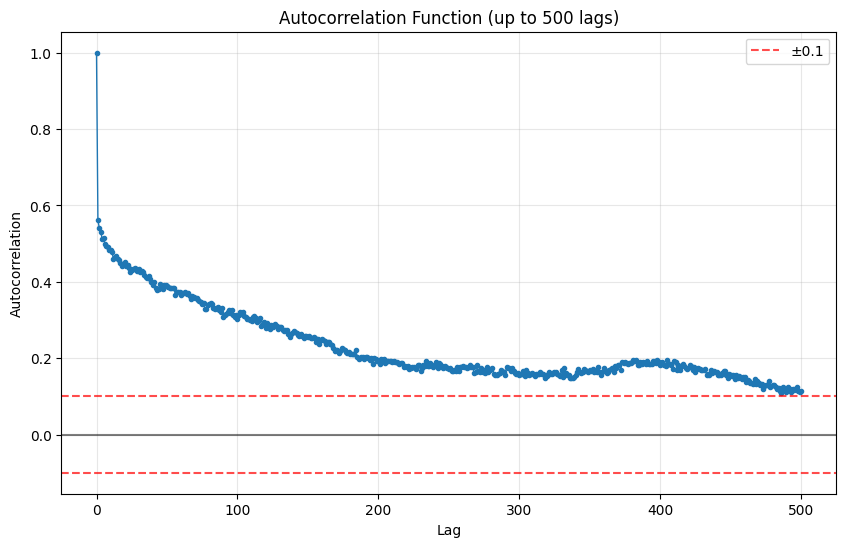

RMSE autocorrelation plot:


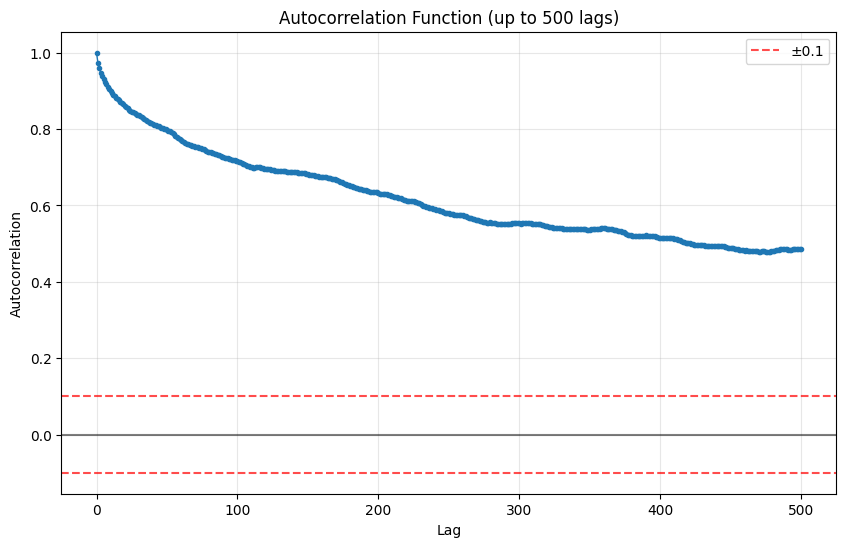

In [13]:
# Analyze each run's results
n_runs = 5

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_default_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_default_run{run_id}.npy')

    print(f"Sigma autocorrelation plot:")
    plot_autocorrelation(sigmas[3000:], nlags=500)
    
    print(f"RMSE autocorrelation plot:")
    plot_autocorrelation(rmses[3000:], nlags=500)

## MTMH
### KPSS test

In [14]:
from diagnosis import segmented_kpss_test

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma convergence analysis:


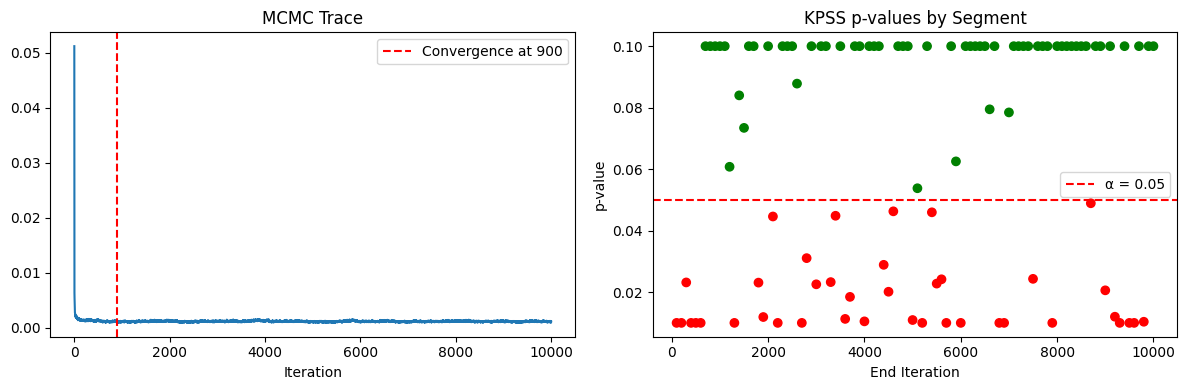

Chain converged: True
Convergence at iteration: 900
Convergence rate: 60.00%

RMSE convergence analysis:


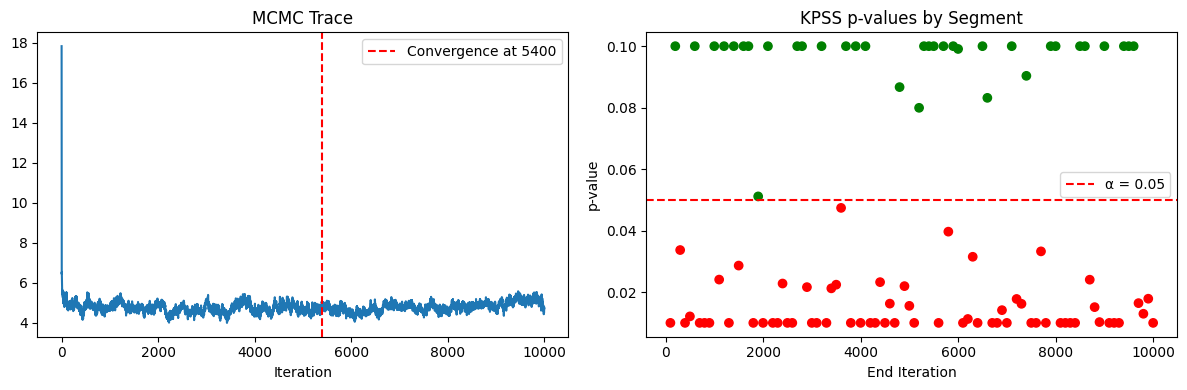

Chain converged: True
Convergence at iteration: 5400
Convergence rate: 35.00%

--- Run 1 ---
Sigma convergence analysis:


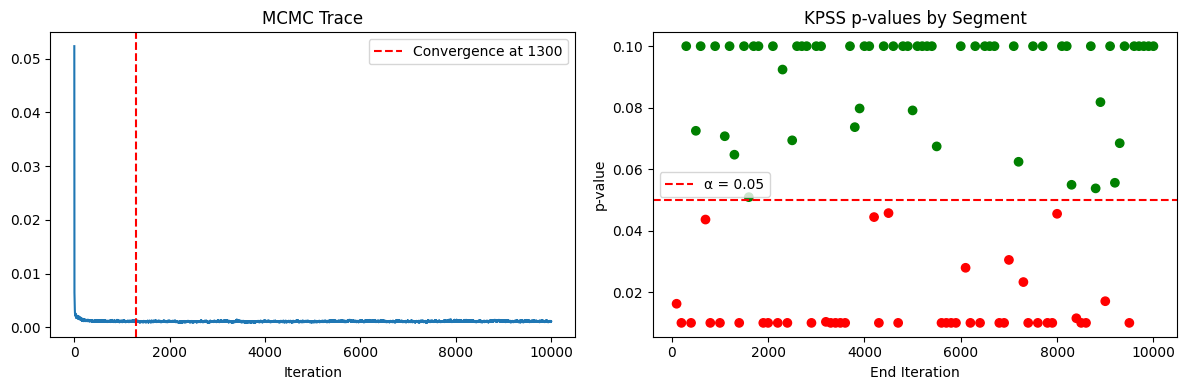

Chain converged: True
Convergence at iteration: 1300
Convergence rate: 58.00%

RMSE convergence analysis:


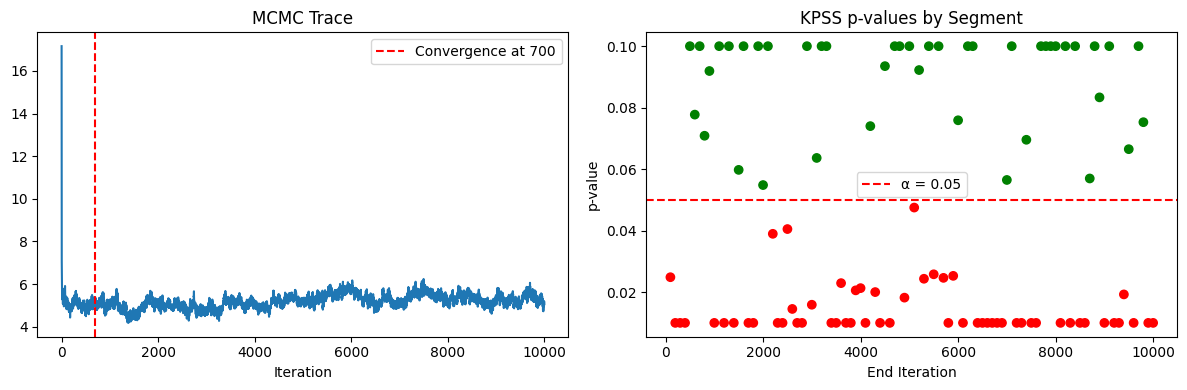

Chain converged: True
Convergence at iteration: 700
Convergence rate: 43.00%

--- Run 2 ---
Sigma convergence analysis:


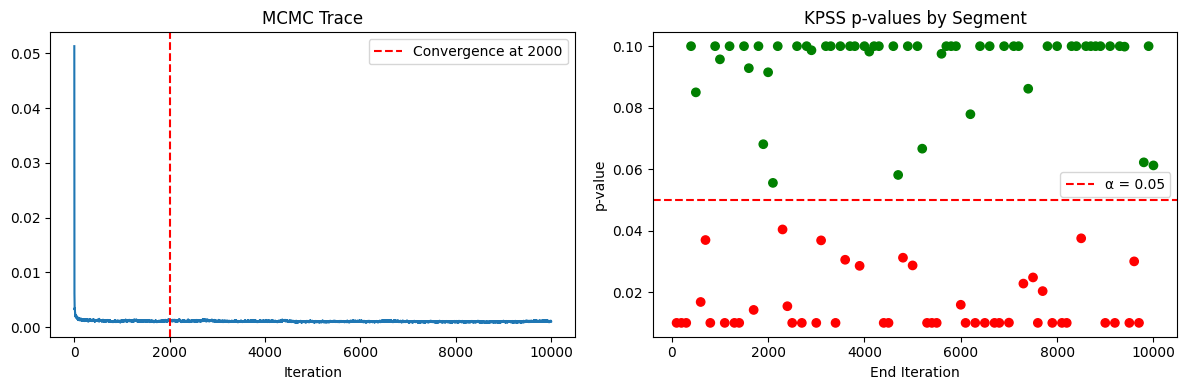

Chain converged: True
Convergence at iteration: 2000
Convergence rate: 54.00%

RMSE convergence analysis:


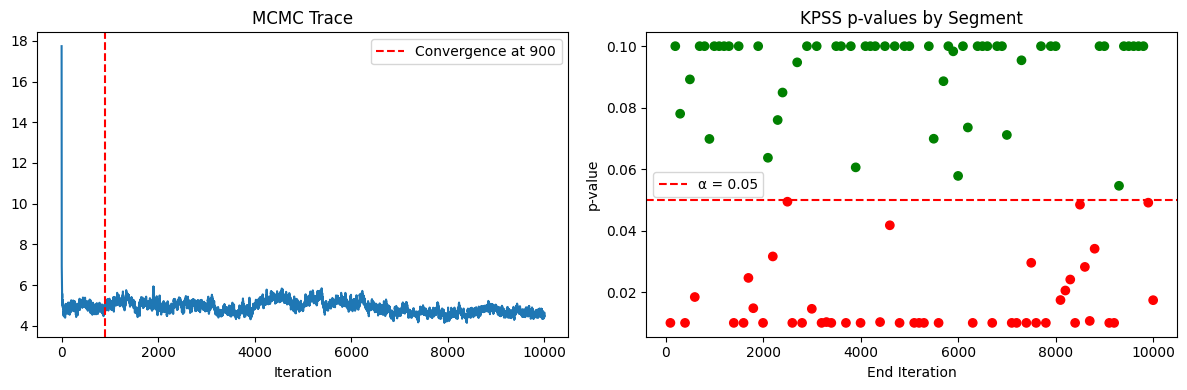

Chain converged: True
Convergence at iteration: 900
Convergence rate: 55.00%

--- Run 3 ---
Sigma convergence analysis:


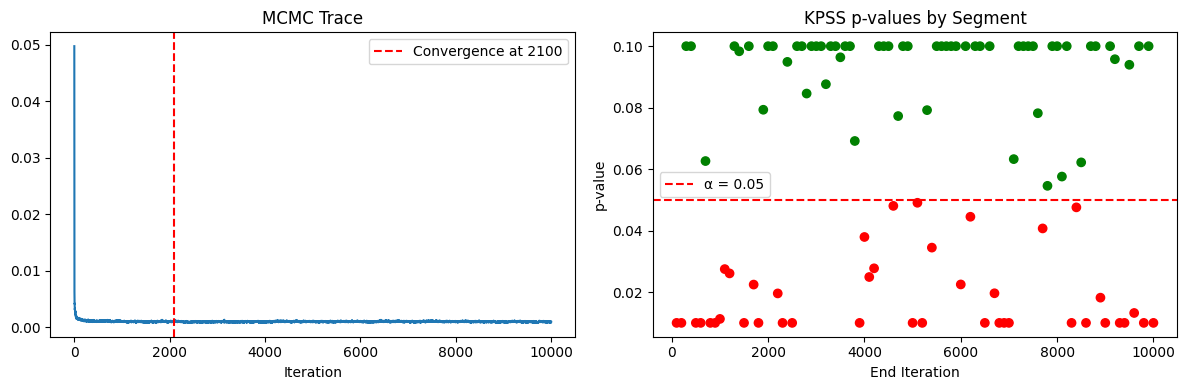

Chain converged: True
Convergence at iteration: 2100
Convergence rate: 58.00%

RMSE convergence analysis:


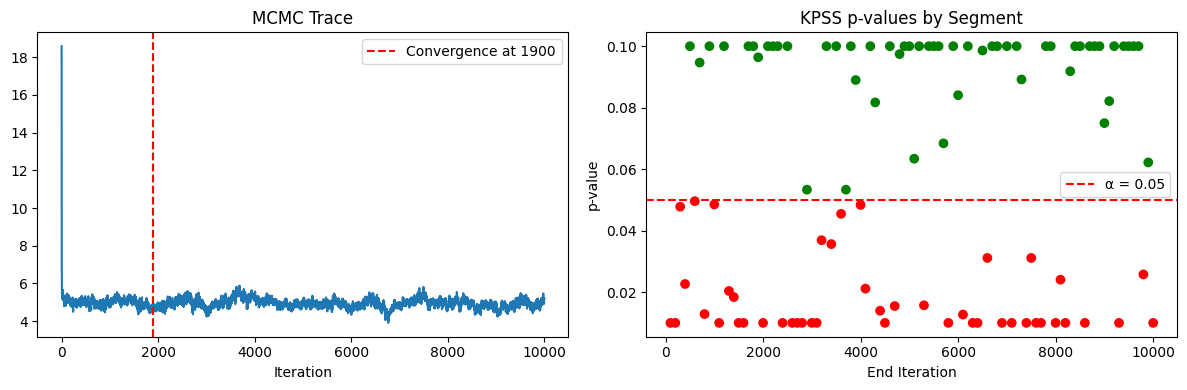

Chain converged: True
Convergence at iteration: 1900
Convergence rate: 54.00%

--- Run 4 ---
Sigma convergence analysis:


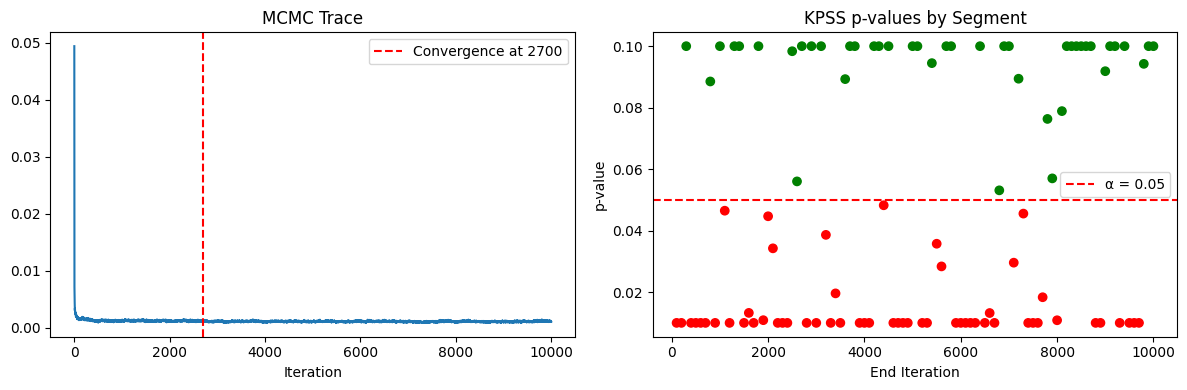

Chain converged: True
Convergence at iteration: 2700
Convergence rate: 43.00%

RMSE convergence analysis:


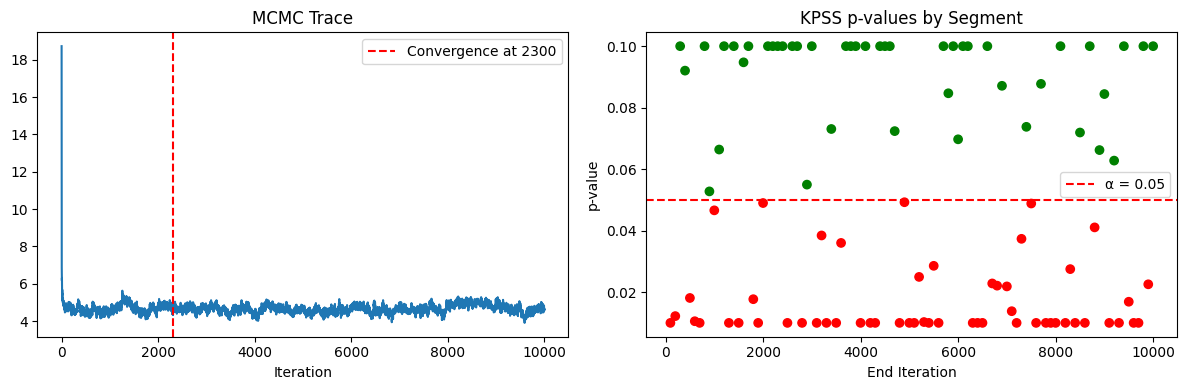

Chain converged: True
Convergence at iteration: 2300
Convergence rate: 45.00%


In [15]:
# Analyze each run's results and collect statistics
n_runs = 5

# Collect convergence statistics
mtmh_sigma_convergence = []
mtmh_rmse_convergence = []
mtmh_sigma_rates = []
mtmh_rmse_rates = []

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_mtmh_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_mtmh_run{run_id}.npy')

    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    mtmh_sigma_rates.append(convergence_result['convergence_rate'])

    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    mtmh_rmse_rates.append(convergence_result['convergence_rate'])

In [16]:
# Print summary statistics for MTMH BART
print("\n=== MTMH BART Summary ===")
if mtmh_sigma_convergence:
    print(f"Sigma - Average convergence iteration: {np.mean(mtmh_sigma_convergence):.0f}")
else:
    print("Sigma - No convergence detected")
print(f"Sigma - Average convergence rate: {np.mean(mtmh_sigma_rates):.2%}")

if mtmh_rmse_convergence:
    print(f"RMSE - Average convergence iteration: {np.mean(mtmh_rmse_convergence):.0f}")
else:
    print("RMSE - No convergence detected")
print(f"RMSE - Average convergence rate: {np.mean(mtmh_rmse_rates):.2%}")


=== MTMH BART Summary ===
Sigma - Average convergence iteration: 1800
Sigma - Average convergence rate: 54.60%
RMSE - Average convergence iteration: 2240
RMSE - Average convergence rate: 46.40%


### ESS

In [17]:
# Add logging configuration before importing arviz
import logging
logging.getLogger('arviz.preview').setLevel(logging.WARNING)
import arviz as az

In [18]:
# Analyze each run's results
n_runs = 5

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_mtmh_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_mtmh_run{run_id}.npy')

    print(f"Sigma ess value: {az.ess(sigmas[3000:].reshape(1, -1), relative=True).item():.6f}")
    print(f"RMSE ess value: {az.ess(rmses[3000:].reshape(1, -1), relative=True).item():.6f}")

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma ess value: 0.007443
RMSE ess value: 0.000908

--- Run 1 ---
Sigma ess value: 0.005743
RMSE ess value: 0.002036

--- Run 2 ---
Sigma ess value: 0.001498
RMSE ess value: 0.000276

--- Run 3 ---
Sigma ess value: 0.016182
RMSE ess value: 0.004305

--- Run 4 ---
Sigma ess value: 0.015260
RMSE ess value: 0.003204


### Autocorrelation

In [19]:
from diagnosis import plot_autocorrelation

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma autocorrelation plot:


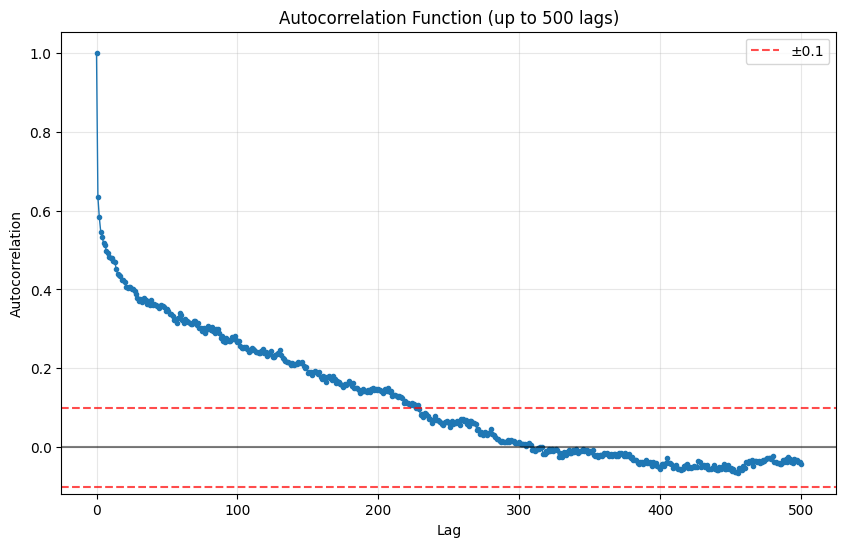

RMSE autocorrelation plot:


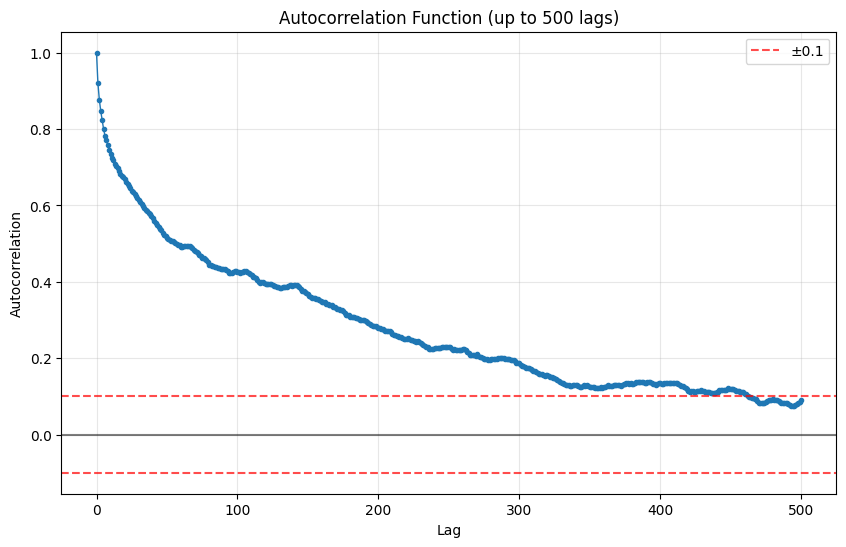


--- Run 1 ---
Sigma autocorrelation plot:


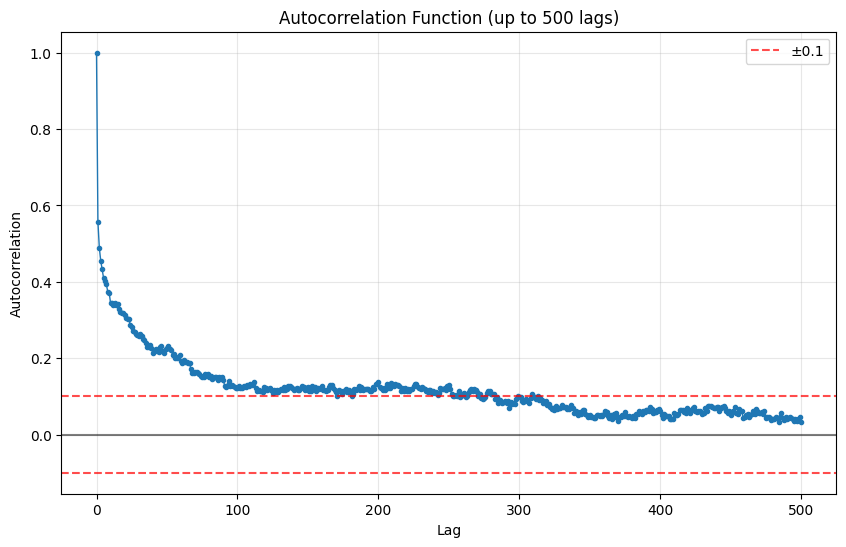

RMSE autocorrelation plot:


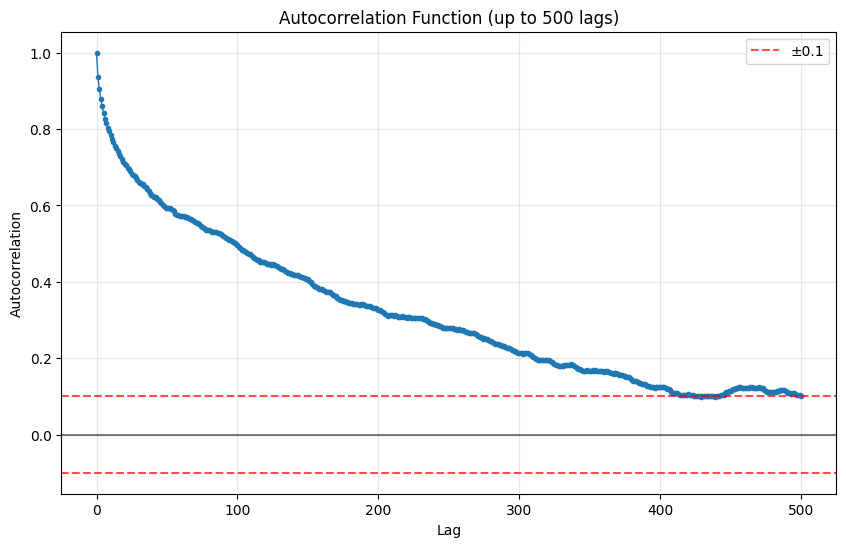


--- Run 2 ---
Sigma autocorrelation plot:


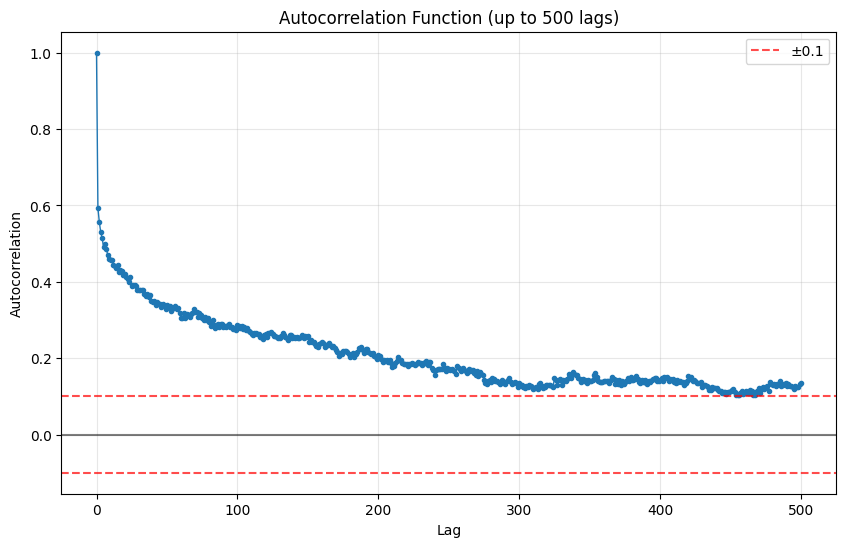

RMSE autocorrelation plot:


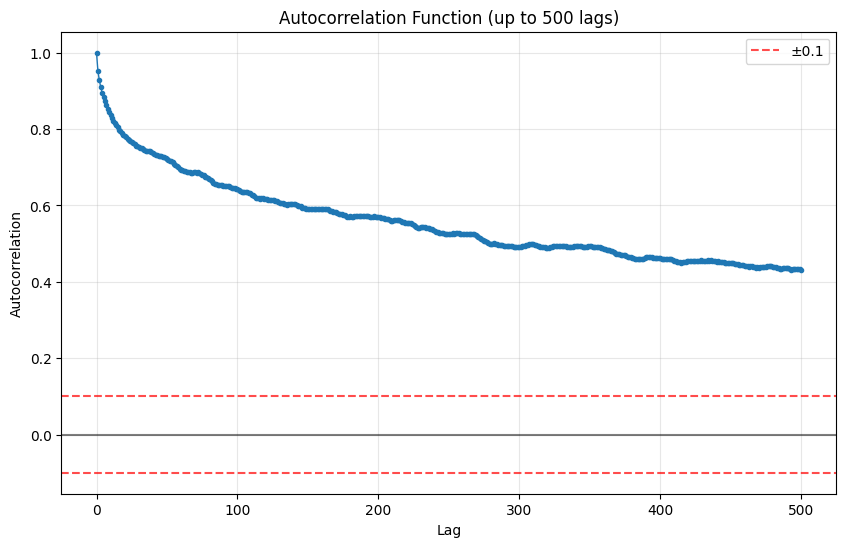


--- Run 3 ---
Sigma autocorrelation plot:


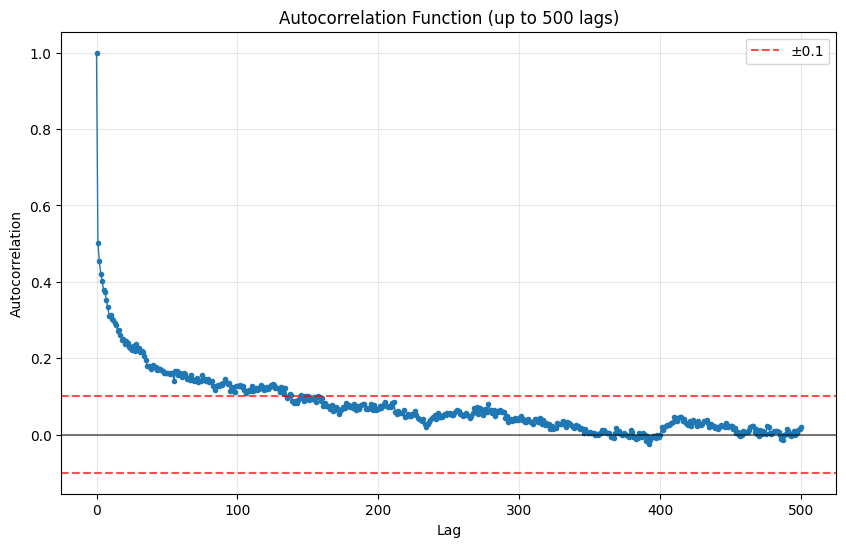

RMSE autocorrelation plot:


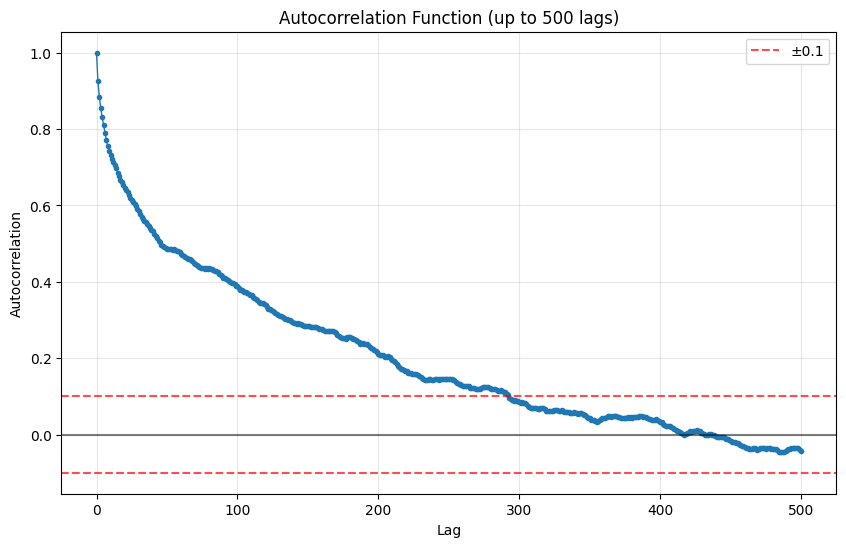


--- Run 4 ---
Sigma autocorrelation plot:


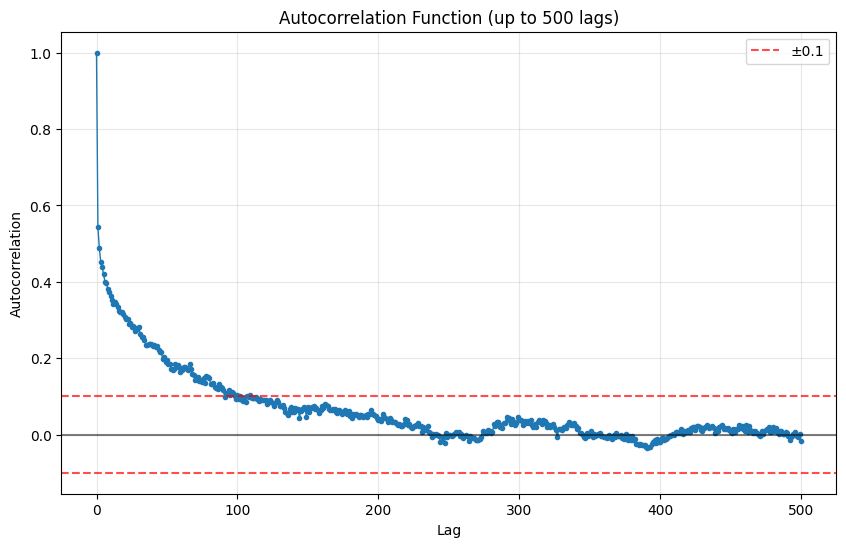

RMSE autocorrelation plot:


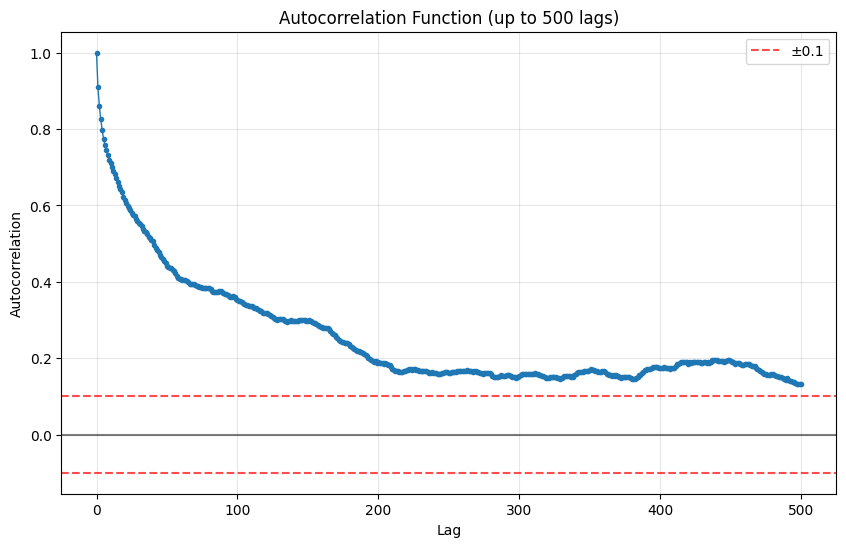

In [20]:
# Analyze each run's results
n_runs = 5

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_mtmh_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_mtmh_run{run_id}.npy')

    print(f"Sigma autocorrelation plot:")
    plot_autocorrelation(sigmas[3000:], nlags=500)
    
    print(f"RMSE autocorrelation plot:")
    plot_autocorrelation(rmses[3000:], nlags=500)